# Udacity UD120 - Final Project
###  by: Josh Haines - Q4 2015


## Project Code & Comments

import statments

In [5]:
import sys
import pickle
sys.path.append("../tools/")
from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data

# Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file : data_dict = pickle.load(data_file)

##### Examine the Dataset

Let's do some exploring of the data to get a feel for what is in it...
This is the Enron corpus dataset.  It includes emails, financial, and investigative information on various Enron employees from the days around their major scandal.  The data is organized as a dict of dicts which is a slick way of saying it's a dictionary of dictionaries.  You can think of it organized like the following: 

* Sally
    * Salary: X
    * Emails Sent: Y
    * Person of Interest: true
    * ... 21 "features" total per person
* John
    * Salary: X'
    * Emails Sent: Y'
    * Person of Interest: false
    * ...
* ... 146 People Total

The dataset is mostly complete, but a few places are empty.  In these places the value "NaN" is put in to not break the code.  We'll have to take this into accounts

A few definitions may help you make sense of this data.
POI - Person of Interest (in the Enron investigation)
Names - Are formatted as "LAST FIRST MI"
Emails - Some features are listed as "from this person to poi" that would mean the number in that field is the number of emails this person sent to people on the POI list.

In [6]:
print('Number of People in the dataset: {}'.format(len(data_dict)))
print
print('A list of the people in the dataset.')
print('{}'.format([i for i in data_dict]))
print
print("All features for a single person, let's use the CEO: Jeff Skilling.")
print('{}'.format(data_dict["SKILLING JEFFREY K"]))


Number of People in the dataset: 146

A list of the people in the dataset.
['METTS MARK', 'BAXTER JOHN C', 'ELLIOTT STEVEN', 'CORDES WILLIAM R', 'HANNON KEVIN P', 'MORDAUNT KRISTINA M', 'MEYER ROCKFORD G', 'MCMAHON JEFFREY', 'HORTON STANLEY C', 'PIPER GREGORY F', 'HUMPHREY GENE E', 'UMANOFF ADAM S', 'BLACHMAN JEREMY M', 'SUNDE MARTIN', 'GIBBS DANA R', 'LOWRY CHARLES P', 'COLWELL WESLEY', 'MULLER MARK S', 'JACKSON CHARLENE R', 'WESTFAHL RICHARD K', 'WALTERS GARETH W', 'WALLS JR ROBERT H', 'KITCHEN LOUISE', 'CHAN RONNIE', 'BELFER ROBERT', 'SHANKMAN JEFFREY A', 'WODRASKA JOHN', 'BERGSIEKER RICHARD P', 'URQUHART JOHN A', 'BIBI PHILIPPE A', 'RIEKER PAULA H', 'WHALEY DAVID A', 'BECK SALLY W', 'HAUG DAVID L', 'ECHOLS JOHN B', 'MENDELSOHN JOHN', 'HICKERSON GARY J', 'CLINE KENNETH W', 'LEWIS RICHARD', 'HAYES ROBERT E', 'MCCARTY DANNY J', 'KOPPER MICHAEL J', 'LEFF DANIEL P', 'LAVORATO JOHN J', 'BERBERIAN DAVID', 'DETMERING TIMOTHY J', 'WAKEHAM JOHN', 'POWERS WILLIAM', 'GOLD JOSEPH', 'BANNANTINE 

In [7]:
print("Let's see all the salaries and number of emails sent for everyone in the dataset.")
print
print('Name -- Salary -- Emails Sent')
print
for i in sorted(data_dict):
    print('{} -- ${} -- {}'.format(i, data_dict[i]['salary'], data_dict[i]['from_messages']))

Let's see all the salaries and number of emails sent for everyone in the dataset.

Name -- Salary -- Emails Sent

ALLEN PHILLIP K -- $201955 -- 2195
BADUM JAMES P -- $NaN -- NaN
BANNANTINE JAMES M -- $477 -- 29
BAXTER JOHN C -- $267102 -- NaN
BAY FRANKLIN R -- $239671 -- NaN
BAZELIDES PHILIP J -- $80818 -- NaN
BECK SALLY W -- $231330 -- 4343
BELDEN TIMOTHY N -- $213999 -- 484
BELFER ROBERT -- $NaN -- NaN
BERBERIAN DAVID -- $216582 -- NaN
BERGSIEKER RICHARD P -- $187922 -- 59
BHATNAGAR SANJAY -- $NaN -- 29
BIBI PHILIPPE A -- $213625 -- 40
BLACHMAN JEREMY M -- $248546 -- 14
BLAKE JR. NORMAN P -- $NaN -- NaN
BOWEN JR RAYMOND M -- $278601 -- 27
BROWN MICHAEL -- $NaN -- 41
BUCHANAN HAROLD G -- $248017 -- 125
BUTTS ROBERT H -- $261516 -- NaN
BUY RICHARD B -- $330546 -- 1053
CALGER CHRISTOPHER F -- $240189 -- 144
CARTER REBECCA C -- $261809 -- 15
CAUSEY RICHARD A -- $415189 -- 49
CHAN RONNIE -- $NaN -- NaN
CHRISTODOULOU DIOMEDES -- $NaN -- NaN
CLINE KENNETH W -- $NaN -- NaN
COLWELL WESLEY -- 

##### Task 1: Select the Data Features

Deciding on features to use to determine POI status is a tough choice.  I'm leaning towards using the emails features and other features to check association with POIs as my method.  I'll probably do PCA and let the algorithm decide on features just as a test as well.  I better do some visualization first.

Let's start with total emails with POIs vs being a POI

<IPython.core.display.Javascript object>


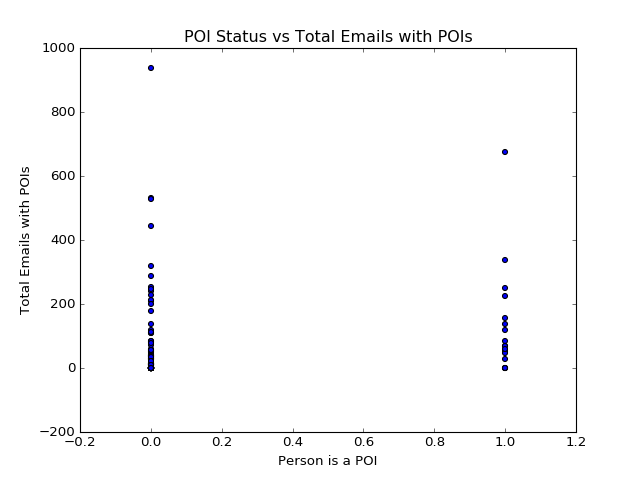

In [14]:
import matplotlib
from matplotlib import pyplot as plt
%matplotlib notebook

emails_with_pois = []
is_poi = []

# make x and y axes for a graph
for i in data_dict:
    emails_with_pois.append(data_dict[i]['from_this_person_to_poi'] + data_dict[i]['from_poi_to_this_person'])
    
    # Build the is_poi list
    if data_dict[i]['poi'] == True:
        is_poi.append(1)
    else:
        is_poi.append(0)
# clean up NaN issues
emails_with_pois = [i if i != 'NaNNaN' else 0 for i in emails_with_pois]

# print('emails_with_pois: {}'.format(emails_with_pois))
# print('is_poi: {}'.format(is_poi))
plt.scatter(is_poi, emails_with_pois)
plt.xlabel('Person is a POI')
plt.ylabel('Total Emails with POIs')
plt.title('POI Status vs Total Emails with POIs')
plt.show()

Eh, that one doesn't really show anything interesting.  Let's try another one.  How about we plot total money (stock, salary, and bonus) vs emails with POIs for POIs and non-POIs.

In [44]:
# POI compensation vs emails
from operator import add
poi_compensation = []
poi_emails_with_pois = []
for i in data_dict:  # Loop all people
    salary_poi = 0
    stock_options_poi = 0
    bonus_poi = 0
    if data_dict[i]['poi'] == True:  # Only act if person is a POI
        if data_dict[i]['salary'] != 'NaN':
            salary_poi = data_dict[i]['salary']
        if data_dict[i]['exercised_stock_options'] != 'NaN':
            stock_options_poi = data_dict[i]['exercised_stock_options']
        if data_dict[i]['bonus'] != 'NaN':
            bonus_poi = data_dict[i]['bonus']
        poi_compensation.append(salary_poi + stock_options_poi + bonus_poi)
        
#         for x in range(len(poi_compensation)):
#             if poi_compensation[x] == 'NaN':
#                 poi_compensation[x] = 0
#             print('poi_compensation: {}'.format(poi_compensation[x]))
print poi_compensation


[7281294, 1488542, 2584439, 1024305, 2036240, 5656276, 42420705, 1628601, 6417134, 1740698, 1490189, 21964811, 25961258, 8466955, 30766064, 1681683, 1415189, 1259703]


In [ ]:
# features_list is a list of strings, each of which is a feature name.
# The first feature must be "poi".
features_list = ['poi','salary'] # You will need to use more features

##### Task 2: Remove Outliers

In [ ]:
# code here

##### Task 3: Create New Features

In [ ]:
# Store to my_dataset for easy export below.
my_dataset = data_dict

In [ ]:
# Extract features and labels from dataset for local testing
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

##### Task 4: Use Classifiers

In [ ]:
# Please name your classifier clf for easy export below.
# Note that if you want to do PCA or other multi-stage operations,
# you'll need to use Pipelines. For more info:
# http://scikit-learn.org/stable/modules/pipeline.html

# Provided to give you a starting point. Try a variety of classifiers.
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()

##### Task 5: Tune the Classifier

In [ ]:
# Tune your classifier to achieve better than .3 precision and recall 
# using our testing script. Check the tester.py script in the final project
# folder for details on the evaluation method, especially the test_classifier
# function. Because of the small size of the dataset, the script uses
# stratified shuffle split cross validation. For more info: 
# http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html

# Example starting point. Try investigating other evaluation techniques!
from sklearn.cross_validation import train_test_split
features_train, features_test, labels_train, labels_test = \
    train_test_split(features, labels, test_size=0.3, random_state=42)

##### Task 6: Output Your Variables

In [ ]:
# Dump your classifier, dataset, and features_list so anyone can
# check your results. You do not need to change anything below, but make sure
# that the version of poi_id.py that you submit can be run on its own and
# generates the necessary .pkl files for validating your results.

dump_classifier_and_data(clf, my_dataset, features_list)

## Project Questions

*Q1: Summarize for us the goal of this project and how machine learning is useful in trying to accomplish it. As part of your answer, give some background on the dataset and how it can be used to answer the project question. Were there any outliers in the data when you got it, and how did you handle those?  
[relevant rubric items: “data exploration”, “outlier investigation”]*

A1: The goal of the project is to use the skills learned in UD120 to be able to predict an outcome from ambigious data.  In this case, we'll be trying to find "Persons of Interest" (POI) from various types of information related to employees working at Enron.  We'll have financial, email, and POI data for a list of people.  The data came from the various trials the company and its employees went through.  It is rare that we would have comprehensive corporate data like this.

Machine learning can make these types of analyses much faster and more accurate than having a team of forensic accountants trying to comb through the data and guess at connections.  We can use the machine learning tools from UD120 to dissect the data, compare features, and become accurate at predicting an outcome based on different types of data inputs.

*Q2: What features did you end up using in your POI identifier, and what selection process did you use to pick them? Did you have to do any scaling? Why or why not? As part of the assignment, you should attempt to engineer your own feature that does not come ready-made in the dataset -- explain what feature you tried to make, and the rationale behind it. (You do not necessarily have to use it in the final analysis, only engineer and test it.) In your feature selection step, if you used an algorithm like a decision tree, please also give the feature importances of the features that you use, and if you used an automated feature selection function like SelectKBest, please report the feature scores and reasons for your choice of parameter values.  
[relevant rubric items: “create new features”, “properly scale features”, “intelligently select feature”]*

A2: lorem

*Q3: What algorithm did you end up using? What other one(s) did you try? How did model performance differ between algorithms?  
[relevant rubric item: “pick an algorithm”]*

A3: lorem

*Q4: What does it mean to tune the parameters of an algorithm, and what can happen if you don’t do this well?  How did you tune the parameters of your particular algorithm? (Some algorithms do not have parameters that you need to tune -- if this is the case for the one you picked, identify and briefly explain how you would have done it for the model that was not your final choice or a different model that does utilize parameter tuning, e.g. a decision tree classifier).
[relevant rubric item: “tune the algorithm”]*

A4: lorem

*Q5: What is validation, and what’s a classic mistake you can make if you do it wrong? How did you validate your analysis?  
[relevant rubric item: “validation strategy”]*

A5: lorem

*Q6: Give at least 2 evaluation metrics and your average performance for each of them.  Explain an interpretation of your metrics that says something human-understandable about your algorithm’s performance.
[relevant rubric item: “usage of evaluation metrics”]*

A6: lorem